## 1. Optimizations
Go over the implementation of the optimization algorithms discussed in the lecture, and run all the corresponding code cells.

In [1]:
import random
import math

### 1.1. Random optimization
Optimizes overall fitness score by creating $n$ random guesses and selecting the best.

In [2]:
def random_optimize(domain,  fitness_function, n=9999):    
    best_score = None
    best_sol = None
    for iter in range(n):
        # Create a random solution
        # domain[i] represents a range of all valid choices for position i
        r=[random.randint(domain[i][0],domain[i][1])
                      for i in range(len(domain))]        
    
        # Get the cost
        cost=fitness_function(r)
    
        # Compare it to the best one so far
        if best_score is None or cost < best_score:
            best_score = cost
            best_sol = r

    return (best_sol, best_score, n)

### 1.2. Hill climbing optimization
Starts from a random point in solution space, and moves into a direction of a neighboring solution with the better score, until no more such solutions can be found. Often finds a local minimum instead of the global one.

For each position in the solution, the *domain* contains a valid min and max. This prevents from considering invalid solutions.

In [3]:
def hillclimb_optimize(domain, fitness_function):
    # Create an initial random solution
    best_sol=[random.randint(domain[i][0],domain[i][1])
              for i in range(len(domain))]

    # Main loop: until no better neighbors
    iterations = 0
    while 1:
        best_score=fitness_function(best_sol)        
        current_score = best_score
        
        iterations += 1
        
        # Create list of all neighboring solutions
        neighbors=[]

        for j in range(len(domain)):
            # One away in each direction
            # if current best-SOl[j] is not the smallest in the domain 
            # - we can subtract 1
            if best_sol[j]>domain[j][0]: 
                neighbors.append(best_sol[0:j]+[best_sol[j]-1]+best_sol[j+1:])
            # if current best-SOl[j] is not the largest in the domain 
            # - we can add 1 
            if best_sol[j]< domain[j][1]:
                neighbors.append(best_sol[0:j]+[best_sol[j]+1]+best_sol[j+1:])

        # See what the best solution amongst the neighbors is        
        for j in range(len(neighbors)):
            cost = fitness_function(neighbors[j])
            if cost < best_score:
                best_score = cost
                best_sol = neighbors[j]

        # If there's no improvement, then we've reached the local min
        if best_score == current_score:
            break
            
        if best_score == 0:
            break

    return (best_sol, best_score, iterations)

### 1.3. Simulated annealing optimization
We start with a random point in the search space as before. We generate a random neighbor. If the score of the neighbor is better than the current score - we replace current solution with it. If the score is worse - we still can accept the solution, depending on the phase of the algorithm, reflected in the decreasing value of temperature $T$. In the beginning we set the temperature high, and the probability of selecting worse solution is higher. This allows to better explore the search space and get out of the local minimum. The temperature gradually decreases, and so at the end we do not accept worse solutions.

The criterion of accepting ''bad'' solutions is given by the following formula:

$p=e^{\frac{-\Delta F}{T}}>R(0,1)$

where $T$ is the current temperature, $R(0,1)$ is a random number between $0$ and $1$, and $\Delta F$ is the difference between the fitness score of new solution and the old solution.

In [4]:
def annealing_optimize(domain, fitness_function,
                      T=10000.0,cool=0.95,step=1):
    # Create an initial random solution
    best_sol =[random.randint(domain[i][0],domain[i][1])
              for i in range(len(domain))]
    
    iterations = 0
    while T > 0.1:
        iterations += 1
        
        # Choose one of the indices at random
        i = random.randint(0,len(domain)-1) #randint selects INCLUDING the max

        # Choose a random direction to change it
        dir = random.randint(-step,step)

        # Create a new solution with one of the values changed into a random direction
        sol_b = best_sol[:]
        sol_b [i] += dir
        
        # check that it is within allowed domain
        # if sol_b[i] smaller than the min allowed value
        # replace it with the smallest from the domain
        if sol_b [i] < domain[i][0]:
            sol_b [i] = domain[i][0]
        # if sol_b[i] larger than the max allowed value
        # replace it with the largest from the domain
        elif sol_b [i] > domain[i][1]:
            sol_b [i] = domain[i][1] 

        # Calculate the cost of the current_best solution
        best_score = fitness_function(best_sol)
        
        if best_score == 0:
            break
            
        # Calculate score of a new solution   
        b_score = fitness_function(sol_b)
        
        # If T is really large, exp -> 0, and p -> 1
        # If T is small, exp is defined by difference between new and old score
        # If T is very small, exp -> infinity, p -> 0 
        exp = -(b_score - best_score)/T        
        p = pow (math.e, exp)

        # Is it better, 
        # or does it make the probability cutoff?
        if b_score < best_score or p > random.random():
            best_sol = sol_b        
        
        # Decrease the temperature
        T = T*cool

    return (best_sol, fitness_function(best_sol), iterations)

### 1.4. Genetic algorithm optimization
The algorithm starts with a population of $popsize$ random individuals, and in each generation selects the $elite\_ratio$ percents with the best fitness score (elite). It continues to the next generation with this group. In order to enrich the genetic pool in the current generation, the algorithm adds random mutations with probability $mut\_prob$ and mating (crossover) between the members of the elite group. After predefined number of generations $n$, the algorithm returns the individual with the best fitness score. 

In [5]:
def genetic_optimize (domain, fitness_function,
                    popsize=100, step=1,
                    mut_prob=0.2, elite_ratio=0.2, n=100):
    # Mutation Operation
    def mutate(vec):
        # choose random index in the solution
        i=random.randint(0,len(domain)-1)
        # Rooll the dice and with equal probability
        # either increase or decrease value at i by step
        if random.random()<0.5 and (vec[i] - step) >= domain[i][0]:
            return vec[0:i]+[vec[i]-step]+vec[i+1:]
        elif (vec[i]+step) <= domain[i][1]:
            return vec[0:i]+[vec[i]+step]+vec[i+1:]
        return vec

    # Crossover Operation
    def crossover(r1,r2):
        i=random.randint(0,len(domain)-1)
        return r1[0:i]+r2[i:]

    # Build the initial population of random solutions
    pop=[]
    for i in range(popsize):
        vec = [random.randint(domain[i][0],domain[i][1])
               for i in range(len(domain))]
        pop.append(vec)

    # How many winners from each generation?
    topelite=int(elite_ratio*popsize)

    # Main loop
    generations = 0
    for i in range(n):
        # This is the list of all solutions in the population together with their fitness scores
        scores = [(fitness_function(sol_vect), sol_vect) for sol_vect in pop]
        
        # We sort this list by score
        scores.sort()

        # See what is current top best score
        if scores[0][0] == 0:
            break
        
        generations += 1
        
        # this is a list of just the solutions extracted from the sorted by score
        ranked_solutions = [sol_vect for (cost, sol_vect) in scores]

        # Build next gen population
        # Start with the pure winners
        pop = ranked_solutions[0:topelite]

        # Add mutated and bred forms of the winners
        while len(pop) < popsize:
            if random.random() < mut_prob:
                # Mutation. Select random individual from elite group and mutate
                c = random.randint(0,topelite-1)
                pop.append(mutate(ranked_solutions[c]))
            else:
                # Crossover. Select 2 random individuals from elite group and cross
                c1 = random.randint(0, topelite-1)
                c2 = random.randint(0, topelite-1)
                pop.append(crossover(ranked_solutions[c1],ranked_solutions[c2]))
                
    # After n generations return the top scored solution from the sorted list of scores
    return (scores[0][1], scores[0][0], generations)

## 2. Group schedule optimization
We want to optimize the group schedule for 6 family memebers, which come from different cities to the meetup in New York. 

In [6]:
people = [  ('Seymour', 'BOS'),
            ('Franny', 'DAL'),
            ('Zooey', 'CAK'),
            ('Walt', 'MIA'),
            ('Buddy', 'ORD'),
            ('Les', 'OMA')]
# LaGuardia airport code - New York
destination = 'LGA'

### 2.1. Available flights
There are many flights per day to LGA from all these locations. Some sample flights are given in file [flights.txt](flights.txt). Each line in this file contains origin, destination, departure time, arrival time and ticket price in a comma-separated format.

To have an efficient access to the information in this file, we load the data into a dictionary, where the key is a tuple (origin,destination) and the value is the list of all different flights and their details for a given key.

In [7]:
flights = {}
# Create list of flights for each (origin,destination)
f = open('flights.txt')
for line in f:
    origin, dest, depart, arrive, price = line.strip().split(',')
    # If no such key (origin,dest) - create it and init empty list
    flights.setdefault((origin, dest), [])

    # Add details to the list of possible flights
    flights[(origin, dest)].append((depart, arrive, int(price)))

In [8]:
import time

# Useful function which converts 'hour:min' into minutes
def getminutes(t):
    x = time.strptime(t,'%H:%M')
    return x[3]*60+x[4]

getminutes("20:23")

1223

### 2.2. Representing solutions
Our sample of flight data contains 8 distinct flights for each combination of (origin,destination). The challenge is: for each family memebr to select one inbound flight (from their hometown to NYC) and one outbound flight (from NYC to their hometown) such that the entire schedule has an overall minimum possible cost.

To find solution using optimization algorithms, we need to represent each possible solution so it is easy to process and modify it in code. One posible representation is a list containing an index (0-7) of inbound flight and an index (0-7) of outbound flight for each family member.

For example list `t=[1,4,3,2,7,3,6,3,2,4,5,3]` encodes the solution in which Seymour (person 0) takes the second flight of the day from Boston to NYC `(t[0]=1)` and the fifth flight of the day from NYC to Boston `(t[1]=4)`.

This representation is good for the algorithm, but we need to be able to interpret the final solution by humans.  

In [9]:
# Displays the resulting schedule found by an algorithm
def print_schedule(r):
    for d in range(len(r)//2):
        name = people[d][0]
        origin = people[d][1]
        out = flights[(origin,destination)][int(r[d])]
        ret = flights[(destination,origin)][int(r[d+1])]
        print('%10s%10s %5s-%5s $%3s %5s-%5s $%3s' % (name, origin,
                                            out[0], out[1], out[2],
                                            ret[0], ret[1], ret[2]))
        
s = [1,4,3,2,7,3,6,3,2,4,5,3]
print_schedule(s)

   Seymour       BOS  8:04-10:11 $ 95 12:08-14:05 $142
    Franny       DAL 12:19-15:25 $342 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189  9:58-12:56 $249
      Walt       MIA  9:15-12:29 $225 16:50-19:26 $304
     Buddy       ORD 16:43-19:00 $246 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 15:07-17:21 $129


We also need to define a domain for each flight index. Because each (origin,destination) has precisely 8 possible flights, the min flight index is 0 and the max is 7. 

In [10]:
domain = [(0, 8)] * (len(people) * 2)

### 2.3. Scoring solutions
Deciding on how to score each solution is the most non-trivial task in the design of optimization algorithms. 

In [11]:
def schedule_cost(sol):
    totalprice = 0
    latestarrival = 0
    earliestdep = 24 * 60

    for d in range(len(sol) // 2):
        # Get the inbound and outbound flights
        origin = people[d][1]
        outbound = flights[(origin, destination)][int(sol[d])]
        returnf = flights[(destination, origin)][int(sol[d + 1])]

        # Total price is the ticket price 
        # of all outbound and return flights
        totalprice += outbound[2]
        totalprice += returnf[2]

        # Track the latest arrival and earliest departure
        if latestarrival < getminutes(outbound[1]):
            latestarrival = getminutes(outbound[1])
        if earliestdep > getminutes(returnf[0]):
            earliestdep = getminutes(returnf[0])

    # Family memebrs want to share transportation to/from the airport
    # Every person must wait at the airport until the latest person arrives.
    # They also must arrive at the same time and wait for their flights.
    totalwait = 0
    for d in range(len(sol) // 2):
        origin = people[d][1]
        outbound = flights[(origin, destination)][int(sol[d])]
        returnf = flights[(destination, origin)][int(sol[d + 1])]
        totalwait += latestarrival - getminutes(outbound[1])
        totalwait += getminutes(returnf[0]) - earliestdep

    # Does this solution require an extra day of car rental? 
    # That will be additional $50!
    if latestarrival > earliestdep:
        totalprice += 50

    return totalprice + totalwait

In [12]:
schedule_cost(s)

5285

### 2.4. Optimizing
#### Random optimization
Can we improve cost by creating 10000 random schedules and selecting the best?

In [13]:
sol, sol_cost, n = random_optimize(domain,  schedule_cost, 10000)
print("\n-----------Random optimize----------")
print("Total cost for {} trials is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Random optimize----------
Total cost for 10000 trials is:2591

   Seymour       BOS 12:34-15:02 $109 10:33-12:03 $ 74
    Franny       DAL 10:30-14:57 $290 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189 10:32-13:16 $139
      Walt       MIA 11:28-14:40 $248 12:37-15:05 $170
     Buddy       ORD 12:44-14:17 $134 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 11:07-13:24 $171


#### Hill climbing
Can we get a more optimized schedule?

In [14]:
sol, sol_cost, n = hillclimb_optimize(domain, schedule_cost)
print("\n-----------Hill climb optimize----------")
print("Total cost after {} downhill steps is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Hill climb optimize----------
Total cost after 8 downhill steps is:2804

   Seymour       BOS  8:04-10:11 $ 95  6:39- 8:09 $ 86
    Franny       DAL  6:12-10:22 $230  7:57-11:15 $347
     Zooey       CAK  8:27-10:45 $139  8:19-11:16 $122
      Walt       MIA  7:34- 9:40 $324  8:23-11:07 $143
     Buddy       ORD  8:25-10:34 $157  7:50-10:08 $164
       Les       OMA  7:39-10:24 $219  8:04-10:59 $136


#### Simulated annealing
Can we get out of the local minimum trap?

In [15]:
sol, sol_cost, n = annealing_optimize(domain, schedule_cost,cool=0.999)
print("\n-----------Annealing optimize----------")
print("Total cost after {} cooling steps is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Annealing optimize----------
Total cost after 11508 cooling steps is:2868

   Seymour       BOS 17:11-18:30 $108 15:25-16:58 $ 62
    Franny       DAL 15:44-18:55 $382 17:14-20:59 $277
     Zooey       CAK 17:08-19:08 $262 15:50-18:45 $243
      Walt       MIA 15:34-18:11 $326 15:23-18:49 $150
     Buddy       ORD 15:58-18:40 $173 17:06-20:00 $ 95
       Les       OMA 16:51-19:09 $147 15:07-17:21 $129


#### Genetic algorithm
Can biology help?

In [16]:
sol, sol_cost, n = genetic_optimize(domain, schedule_cost,
                                popsize=2048, mut_prob=0.25,
                                elite_ratio=0.1, n=100)
print("\n-----------Genetic algorithme----------")
print("Total cost after {} generations is:{}\n".format(n, sol_cost))
print_schedule(sol)


-----------Genetic algorithme----------
Total cost after 100 generations is:2591

   Seymour       BOS 12:34-15:02 $109 10:33-12:03 $ 74
    Franny       DAL 10:30-14:57 $290 10:51-14:16 $256
     Zooey       CAK 10:53-13:36 $189 10:32-13:16 $139
      Walt       MIA 11:28-14:40 $248 12:37-15:05 $170
     Buddy       ORD 12:44-14:17 $134 10:33-13:11 $132
       Les       OMA 11:08-13:07 $175 11:07-13:24 $171


## 3. Dorm assignment optimization [Your turn!]
### 3.1. Problem setup
There are 5 dorms, each with 2 spaces available and 10 students
vying for spots. Each student has first and second choices.

In [17]:
# The dorms, each of which has two available spaces
dorms=['Dolliver','Crosby','Hill','Carriage','MODs']

# People, along with their first and second choices
prefs=[('Daniel', ('Carriage', 'Hill')),
       ('Steven', ('Dolliver', 'MODs')),
       ('Akarsh', ('Crosby', 'Dolliver')),
       ('Kelvin', ('Dolliver', 'MODs')),
       ('Betty', ('Crosby', 'Carriage')),
       ('Jeff', ('Hill', 'MODs')),
       ('Cat', ('MODs', 'Crosby')),
       ('Michael', ('Carriage', 'Hill')),
       ('Gary', ('Carriage', 'Hill')),
       ('James', ('Hill', 'Crosby'))]

It is clear that every student cannot have their top choice: for example, there are only 2 free spots in Carriage, but 3 students have it as their top choice. We will apply an optimization algorithm to assign students to dorms such that the preferences are satisfied as much as possible for the entire group of students.

### 3.2. Representing solutions
The representation for solutions is a bit trickier for this problem than for the flight
problem. You could, in theory, create a list of numbers, one for each student, where
each number represents the dorm in which you’ve put the student. 

The problem is that this representation doesn’t constrain the solution to only two students in each
dorm. A list of all zeros would indicate that everyone had been placed in Dolliver, which
isn’t a real solution at all.

You need to find a way to represent solutions so that
every one is valid. A valid solution is not necessarily a good solution; it just means
that there are exactly two students assigned to each dorm. 

Hint: One way to do this is to
think of every dorm as having two slots, so that in the example there are ten slots in
total. Each student, in order, is assigned to one of the open slots—the first person
can be placed in any one of the ten, the second person can be placed in any of the
nine remaining slots, and so on.

In [18]:
# Example - list of all possible slots
slots=[]
# Create two slots for each dorm
for i in range(len(dorms)): slots+=[i,i]
    
# This corresponds to 2 slots in Dolliver (0,0), 2 slots in Crosby (1,1) etc.
print(slots)

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]


Each student is assigned one slot from the list of slots, and then this slot is removed. Thus a solution contains a list of 10 entries (one for each student) and at each list position there is an index in the <b>remaining</b> list of slots -- <b>after the slot at the corresponding position has been removed</b>. To understand how it works, we show the `print_solution` function and the sample solution.

In [19]:
def print_solution(sol):
    slots=[]
    # Create two slots for each dorm
    for i in range(len(dorms)):
        slots+=[i,i]

    # Loop over each students assignment
    for i in range(len(sol)):
        x=int(sol[i])
       
        # Choose the slot from the remaining ones
        dorm=dorms[slots[x]]
        
        # Show the student and assigned dorm
        print('%10s %10s %25s' % (prefs[i][0], dorm, prefs[i][1]))
        #print (prefs[i][0],"got:", dorm, " - prefs:", prefs[i][1])

        # Remove this slot
        del slots[x]

In [20]:
print_solution([0,0,0,0,0,0,0,0,0,0])

    Daniel   Dolliver      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin     Crosby      ('Dolliver', 'MODs')
     Betty       Hill    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat   Carriage        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary       MODs      ('Carriage', 'Hill')
     James       MODs        ('Hill', 'Crosby')


<div style="background-color:yellow;">    
    <h3>Task 1. Define domain for each index in the solution</h3>
The first position in the solution corresponds to the slot index assigned to the first student (Daniel). Daniel can have any of the 10 indices, so the min is 0, the max is 9. After we remove one slot from the slots list - there are only 9 elements left. Thus the second student can have any index from 0 to 9, etc.    
 </div> 

In [21]:
# Initialize the domain. 

domain = []
slots_left = len(slots)-1
for indx in range(len(slots)):
    domain.append((0,slots_left))
    slots_left -= 1
    
print(domain)
    

[(0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


<div style="background-color:yellow;">    
    <h3>Task 2. Implement the cost function</h3>
    <ul>
        <li>For each student find which dorm they are assigned. If this dorm is their top choice, add 0 to the overall solution cost.</li>
        <li>If it is their second choice - add 1 to the overall cost.</li>
        <li>If it is not on their list of prefences - add 3 to the cost (far from perfect).</li>
    </ul>
    <b>DO NOT FORGET TO REMOVE THE CORRESPONDING ENTRY FROM THE SLOTS AFTER IT HAS BEEN TAKEN.</b>
</div>

In [22]:
# cost function

def dorm_cost(sol):
    cost=0
    
    
    slots=[]
    # Create two slots for each dorm
    for i in range(len(dorms)):
        slots+=[i,i]

    # Loop over each students assignment
    for i in range(len(sol)):
        x=int(sol[i])
       
        # Choose the slot from the remaining ones
        dorm=dorms[slots[x]]
        
        if dorm == prefs[i][1][0]: 
            # this is student's first preference
            cost += 0
            
        elif dorm == prefs[i][1][1]:
            # this is student's second preference
            cost += 1
            
        else:
            # this dorm is not on their list of preferences
            cost += 3 
        
        # Remove this slot
        del slots[x]
        
    
    return cost

# for testing
sol_testing = [0,0,0,0,0,0,0,0,0,0]
result = dorm_cost(sol_testing)
print(result)

18


<div style="background-color:yellow;">    
    <h3>Task 3. Run optimizations</h3>
Run the optimization algorithms several times in the cells below. Report the parameters and the best results and compare them in the report. The report can be added at the end of the lab in a separate markdown cell.  
 </div> 

#### Random optimize

In [23]:
# this is just running once. Below the bonus question, I will run several times

sol, sol_cost, n = random_optimize(domain,  dorm_cost, 10000)
print("\n-----------Random optimize----------")
print("Total cost for {} trials is:{}\n".format(n, sol_cost))
print_solution(sol)


-----------Random optimize----------
Total cost for 10000 trials is:4

    Daniel   Carriage      ('Carriage', 'Hill')
    Steven       MODs      ('Dolliver', 'MODs')
    Akarsh   Dolliver    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary       Hill      ('Carriage', 'Hill')
     James     Crosby        ('Hill', 'Crosby')


#### Hill climbing

In [24]:
sol, sol_cost, n = hillclimb_optimize(domain, dorm_cost)
print("\n-----------Hill climb optimize----------")
print("Total cost after {} downhill steps is:{}\n".format(n, sol_cost))
print_solution(sol)


-----------Hill climb optimize----------
Total cost after 2 downhill steps is:8

    Daniel   Carriage      ('Carriage', 'Hill')
    Steven   Carriage      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       MODs          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Dolliver      ('Carriage', 'Hill')
      Gary       Hill      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')


#### Simulated annealing

In [25]:
sol, sol_cost, n = annealing_optimize(domain, dorm_cost,cool=0.999)
print("\n-----------Annealing optimize----------")
print("Total cost after {} cooling steps is:{}\n".format(n, sol_cost))
print_solution(sol)


-----------Annealing optimize----------
Total cost after 11508 cooling steps is:5

    Daniel   Carriage      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh       MODs    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       Hill          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael       Hill      ('Carriage', 'Hill')
      Gary   Carriage      ('Carriage', 'Hill')
     James     Crosby        ('Hill', 'Crosby')


#### Genetic algorithm

In [26]:
sol, sol_cost, n = genetic_optimize(domain, dorm_cost,
                                popsize=2048, mut_prob=0.25,
                                elite_ratio=0.1, n=100)
print("\n-----------Genetic algorithme----------")
print("Total cost after {} generations is:{}\n".format(n, sol_cost))
print_solution(sol)


-----------Genetic algorithme----------
Total cost after 100 generations is:2

    Daniel       Hill      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       MODs          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary   Carriage      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')


<div style="background-color:yellow;">    
    <h3>Task 4 [Bonus]. Best solution</h3>
The sample input for this problem is very small. The total number of possible solutions is just 10!=3,628,800. Enumerate all possible solutions and find the one with the lowest cost. Was any of the optimization algorithms was able to find the best solution?  
 </div> 

In [40]:
from itertools import product

min_cost = 70
optimal_sol = []

total_solution_counter = 0

for tuple_sol in product(range(10),range(9),range(8),range(7),range(6),range(5),range(4),range(3),range(2),range(1)):
    p_sol = list(tuple_sol)
    possible_cost = dorm_cost(p_sol)
    if possible_cost < min_cost:
        optimal_sol = p_sol
        min_cost = possible_cost
        
    total_solution_counter += 1

                                          
print("Total number of possible solutions: ", total_solution_counter)
print("\n")
print("The lowest cost possible is: ", min_cost)
print("\n")
print_solution(optimal_sol)


Total number of possible solutions:  3628800


The lowest cost possible is:  2


    Daniel       Hill      ('Carriage', 'Hill')
    Steven   Dolliver      ('Dolliver', 'MODs')
    Akarsh     Crosby    ('Crosby', 'Dolliver')
    Kelvin   Dolliver      ('Dolliver', 'MODs')
     Betty     Crosby    ('Crosby', 'Carriage')
      Jeff       MODs          ('Hill', 'MODs')
       Cat       MODs        ('MODs', 'Crosby')
   Michael   Carriage      ('Carriage', 'Hill')
      Gary   Carriage      ('Carriage', 'Hill')
     James       Hill        ('Hill', 'Crosby')


Examples are adopted from the book ''Programming Collective Intelligence'', by Toby Segaran, 2007.

<div>    
    <h3>Response</h3>
    <p>Graphs below represent 4 algorithms that are run various times</p>
    <p>There are also graphs that compare the parameters with the costs</p>
    <p>
        I also take the average costs of those algorithms in order to compare them since randomness is involved
        and it's hard to compare the best if we are just using the minimum costs. So I iterate 30 times and get
        the average costs of each algorithm from that number of iterations. The parameters of Annealing
        and Genetic algorithms are selected based on the graphs that compare the parameters with the costs. 
    </p>
    <p>
        As we can see from the table, Genetic Algorithm's cost is the lowest. From the bonus question above, we
        can see that the least cost we can get is 2. Genetic Algorithm also provides the minimum cost of 2.
        So Genetic Algorithm is able to find the best solution.
    </p>
    <table>
        <tr>
            <th>Algorithms</th>
            <th>Average Costs</th>
            <th>Additional Parameters</th>
        </tr>
        <tr>
            <td>Random Optimize</td>
            <td>3.47</td>
            <td>
                n = 10000
            </td>
        </tr>
        <tr>
            <td>Hill Climbing</td>
            <td>12.8</td>
            <td></td>
        </tr>
        <tr>
            <td>Simulated Annealing</td>
            <td>4.57</td>
            <td>cool = 0.999</td>
        </tr>
        <tr>
            <td>Genetic Algorithm</td>
            <td>2.0</td>
            <td>
                popsize = 2048,
                mut_prob = 0.25,
                elite_ratio = 0.1,
                n = 100
            </td>
        </tr>
    </table>
</div> 

In [28]:
# I will be comparing the results from multiple runs
import matplotlib.pyplot as plt
%matplotlib inline

# This tells the number of times the algorithm will run
total_no_of_iter = 30

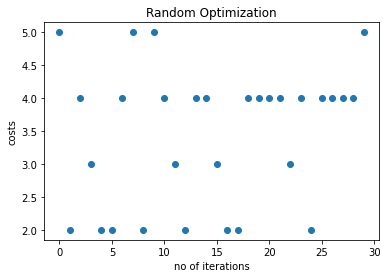

Average of 30 iteration: 3.466666666666667
Min cost:  2


In [29]:
# this is for random optimize algorithm
# this runs random optimize algorithm for various times

random_optimize_costs_lst = []
iteration_num_lst = []


for num in range(0, total_no_of_iter):
    
    sol, sol_cost, n = random_optimize(domain,  dorm_cost, 10000)
    
    iteration_num_lst.append(num)
    random_optimize_costs_lst.append(sol_cost)
    
# graphing    
plt.scatter(iteration_num_lst, random_optimize_costs_lst)

plt.title("Random Optimization")
plt.xlabel("no of iterations")
plt.ylabel("costs")

plt.show()




# getting average and min costs
random_avg = sum(random_optimize_costs_lst)/len(random_optimize_costs_lst)
print("Average of {} iteration: {}".format(total_no_of_iter, random_avg))

min_cost_from_iter = min(random_optimize_costs_lst)
print("Min cost: ", min_cost_from_iter)



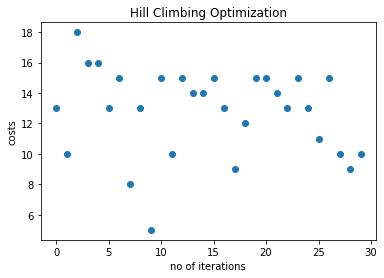

Average of 30 iteration: 12.8
Min cost:  5


In [30]:
# this is for hill climbing algorithm
# running the hill climbing algorithm various times

hill_climbing_optimize_costs_lst = []
iteration_num_lst = []


for num in range(total_no_of_iter):
    
    sol, sol_cost, n = hillclimb_optimize(domain, dorm_cost)
    
    iteration_num_lst.append(num)
    hill_climbing_optimize_costs_lst.append(sol_cost)
    
# graphing    
plt.scatter(iteration_num_lst, hill_climbing_optimize_costs_lst)

plt.title("Hill Climbing Optimization")
plt.xlabel("no of iterations")
plt.ylabel("costs")

plt.show()

# getting average and min costs
hill_avg = sum(hill_climbing_optimize_costs_lst)/len(hill_climbing_optimize_costs_lst)
print("Average of {} iteration: {}".format(total_no_of_iter, hill_avg))

min_cost_from_iter = min(hill_climbing_optimize_costs_lst)
print("Min cost: ", min_cost_from_iter)



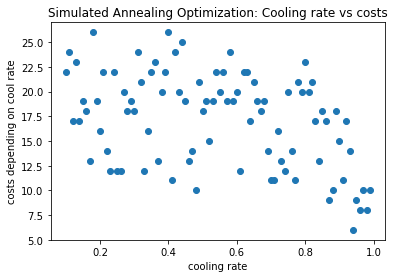

In [31]:
# This is for seeing the costs with different cool rate for Simulated Annealing Optimization

cool_costs_lst = []
cool_rate_lst = []

cool_rate = 0.1
while cool_rate < 1:
    sol, sol_cost, n = annealing_optimize(domain, dorm_cost,cool=cool_rate)
    
    cool_rate_lst.append(cool_rate)
    cool_costs_lst.append(sol_cost)
    
    cool_rate += 0.01

    
# graphing    
plt.scatter(cool_rate_lst, cool_costs_lst)

plt.title("Simulated Annealing Optimization: Cooling rate vs costs")
plt.xlabel("cooling rate")
plt.ylabel("costs depending on cool rate")

plt.show()

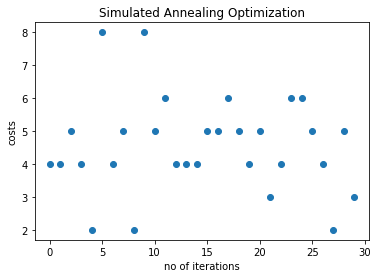

Average of 30 iteration: 4.566666666666666
Min cost:  2


In [32]:
# this is for simulated annealing algorithm
# running the algorithm various times
 

annealing_optimize_costs_lst = []
iteration_num_lst = []

for num in range(total_no_of_iter):
    
    sol, sol_cost, n = annealing_optimize(domain, dorm_cost,cool=0.999)
    
    iteration_num_lst.append(num)
    annealing_optimize_costs_lst.append(sol_cost)

    
# graphing    
plt.scatter(iteration_num_lst, annealing_optimize_costs_lst)

plt.title("Simulated Annealing Optimization")
plt.xlabel("no of iterations")
plt.ylabel("costs")

plt.show()

# getting average and min costs
annealing_avg = sum(annealing_optimize_costs_lst)/len(annealing_optimize_costs_lst)
print("Average of {} iteration: {}".format(total_no_of_iter, annealing_avg))

min_cost_from_iter = min(annealing_optimize_costs_lst)
print("Min cost: ", min_cost_from_iter)

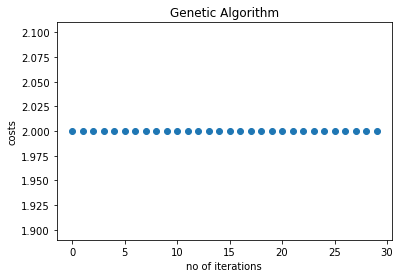

Average of 30 iteration: 2.0
Min cost:  2


In [33]:
# this is for Genetic algorithm
# running the algorithm various times

genetic_optimize_costs_lst = []
iteration_num_lst = []

for num in range(total_no_of_iter):
    
    sol, sol_cost, n = genetic_optimize(domain, dorm_cost,
                                popsize=2048, mut_prob=0.25,
                                elite_ratio=0.1, n=100)
    
    iteration_num_lst.append(num)
    genetic_optimize_costs_lst.append(sol_cost)

    
# graphing    
plt.scatter(iteration_num_lst, genetic_optimize_costs_lst)

plt.title("Genetic Algorithm")
plt.xlabel("no of iterations")
plt.ylabel("costs")

plt.show()

# getting average and min costs
genetic_avg = sum(genetic_optimize_costs_lst)/len(genetic_optimize_costs_lst)
print("Average of {} iteration: {}".format(total_no_of_iter, genetic_avg))

min_cost_from_iter = min(genetic_optimize_costs_lst)
print("Min cost: ", min_cost_from_iter)

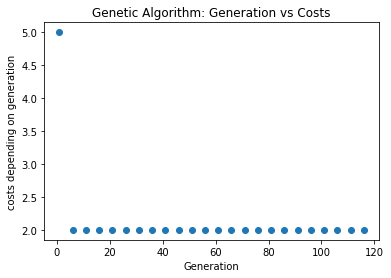

In [34]:
# This is for seeing the costs with different generation for Genetic Algorithm

gen_cost_lst = []
gen_lst = []

gen_counter = 1
while gen_counter < 120:
    sol, sol_cost, n = genetic_optimize(domain, dorm_cost,
                                popsize=2048, mut_prob=0.25,
                                elite_ratio=0.1, n=gen_counter)
    
    gen_lst.append(gen_counter)
    gen_cost_lst.append(sol_cost)
    
    gen_counter += 5

    
# graphing    
plt.scatter(gen_lst, gen_cost_lst)

plt.title("Genetic Algorithm: Generation vs Costs")
plt.xlabel("Generation")
plt.ylabel("costs depending on generation")

plt.show()

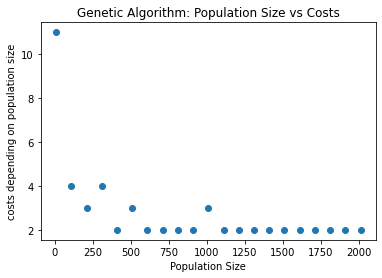

In [35]:
# This is for seeing the costs with different population size for Genetic Algorithm

popsize_cost_lst = []
popsize_lst = []

popsize_counter = 10
while popsize_counter < 2049:
    sol, sol_cost, n = genetic_optimize(domain, dorm_cost,
                                popsize=popsize_counter, mut_prob=0.25,
                                elite_ratio=0.1, n=100)
    
    popsize_lst.append(popsize_counter)
    popsize_cost_lst.append(sol_cost)
    
    popsize_counter += 100

    
# graphing    
plt.scatter(popsize_lst, popsize_cost_lst)

plt.title("Genetic Algorithm: Population Size vs Costs")
plt.xlabel("Population Size")
plt.ylabel("costs depending on population size")

plt.show()

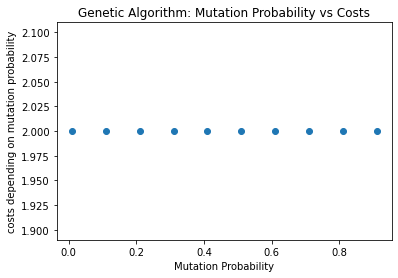

In [36]:
# This is for seeing the costs with different mutation probability for Genetic Algorithm

mut_cost_lst = []
mut_lst = []

mut_counter = 0.01
while mut_counter < 1:
    sol, sol_cost, n = genetic_optimize(domain, dorm_cost,
                                popsize=2048, mut_prob=mut_counter,
                                elite_ratio=0.1, n=100)
    
    mut_lst.append(mut_counter)
    mut_cost_lst.append(sol_cost)
    
    mut_counter += 0.1

    
# graphing    
plt.scatter(mut_lst, mut_cost_lst)

plt.title("Genetic Algorithm: Mutation Probability vs Costs")
plt.xlabel("Mutation Probability")
plt.ylabel("costs depending on mutation probability")

plt.show()

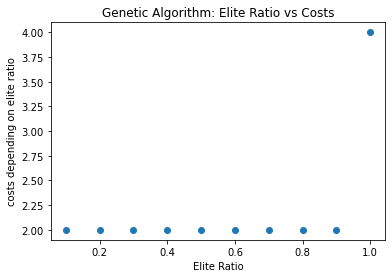

In [37]:
# This is for seeing the costs with different elite ratio for Genetic Algorithm

elite_cost_lst = []
elite_lst = []

elite_counter = 0.1
while elite_counter < 1:
    sol, sol_cost, n = genetic_optimize(domain, dorm_cost,
                                popsize=2048, mut_prob=0.25,
                                elite_ratio=elite_counter, n=100)
    
    elite_lst.append(elite_counter)
    elite_cost_lst.append(sol_cost)
    
    elite_counter += 0.1

    
# graphing    
plt.scatter(elite_lst, elite_cost_lst)

plt.title("Genetic Algorithm: Elite Ratio vs Costs")
plt.xlabel("Elite Ratio")
plt.ylabel("costs depending on elite ratio")

plt.show()